In [1]:
! pip install torch transformers

In [4]:
! pip install numpy prettytable

In [6]:
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import spacy
import pandas as pd
import math
import numpy as np
from prettytable import PrettyTable
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer
import warnings

warnings.filterwarnings("ignore")

In [3]:
with open("ContractNLI-Dataset/test.json") as f:
    document_data = json.load(f)

In [56]:
model = BertForSequenceClassification.from_pretrained("fine-tuned-bert-entailment")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

total_correct = 0
total_predicted = 0

for document in document_data["documents"]:
    correct = 0
    predicted = 0
    
    for annotation_set in document["annotation_sets"]:
        annotations = annotation_set["annotations"]
        for nda, annotation in annotations.items():
            choice = annotation["choice"]
            if choice == "Entailment":
                spans_indices = annotation["spans"]
                document_spans = document["spans"]
                spans = [document_spans[i] for i in spans_indices]
                sliced_texts = [document["text"][start:end] for start, end in spans]

                random_indices = random.sample(range(len(document_spans)), min(len(document_spans) - len(spans_indices), 6))
                random_indices = [i for i in random_indices if i not in spans_indices]
                random_spans = [document_spans[i] for i in random_indices]
                random_sliced_texts = [document["text"][start:end] for start, end in random_spans]

                hypothesis = document_data["labels"][nda]["hypothesis"]
                
                for text in sliced_texts:
                    encoding = tokenizer(text, hypothesis, max_length=512, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask=True)
                    input_ids = encoding["input_ids"]
                    attention_mask = encoding["attention_mask"]

                    with torch.no_grad():
                        logits = model(input_ids, attention_mask=attention_mask)
                        probabilities = logits.logits.softmax(dim=1)

                    if probabilities[0][0] < probabilities[0][1]:
                        correct += 1
                        total_correct += 1
                    predicted += 1
                    total_predicted += 1
                    
                for text in random_sliced_texts:
                    encoding = tokenizer(text, hypothesis, max_length=512, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask=True)
                    input_ids = encoding["input_ids"]
                    attention_mask = encoding["attention_mask"]

                    with torch.no_grad():
                        logits = model(input_ids, attention_mask=attention_mask)
                        probabilities = logits.logits.softmax(dim=1)

                    if probabilities[0][0] > probabilities[0][1]:
                        correct += 1
                        total_correct += 1
                    predicted += 1
                    total_predicted += 1

    print(f"Accuracy on Document {document['id']}: {correct / predicted}")
    
print(f"Total Accuracy: {total_correct / total_predicted}")

Accuracy on Document 1: 0.9529411764705882
Accuracy on Document 2: 0.975609756097561
Accuracy on Document 4: 1.0
Accuracy on Document 5: 0.8928571428571429
Accuracy on Document 6: 0.9859154929577465
Accuracy on Document 8: 0.9545454545454546
Accuracy on Document 11: 0.9193548387096774
Accuracy on Document 18: 0.9545454545454546
Accuracy on Document 21: 0.9042553191489362
Accuracy on Document 22: 0.9759036144578314
Accuracy on Document 23: 0.9259259259259259
Accuracy on Document 24: 0.8157894736842105
Accuracy on Document 25: 0.9629629629629629
Accuracy on Document 26: 0.9830508474576272
Accuracy on Document 30: 0.9113924050632911
Accuracy on Document 31: 0.9428571428571428
Accuracy on Document 36: 0.9156626506024096
Accuracy on Document 38: 0.8823529411764706
Accuracy on Document 40: 0.9545454545454546
Accuracy on Document 41: 1.0
Accuracy on Document 42: 0.9594594594594594
Accuracy on Document 43: 0.9591836734693877
Accuracy on Document 46: 0.9777777777777777
Accuracy on Document 47: 

In [66]:
model = BertForSequenceClassification.from_pretrained("fine-tuned-bert-contradiction")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

total_correct = 0
total_predicted = 0

for document in document_data["documents"]:
    correct = 0
    predicted = 0
    
    for annotation_set in document["annotation_sets"]:
        annotations = annotation_set["annotations"]
        for nda, annotation in annotations.items():
            choice = annotation["choice"]
            if choice == "Contradiction":
                spans_indices = annotation["spans"]
                document_spans = document["spans"]
                spans = [document_spans[i] for i in spans_indices]
                sliced_texts = [document["text"][start:end] for start, end in spans]

                random_indices = random.sample(range(len(document_spans)), min(len(document_spans) - len(spans_indices), 10))
                random_indices = [i for i in random_indices if i not in spans_indices]
                random_spans = [document_spans[i] for i in random_indices]
                random_sliced_texts = [document["text"][start:end] for start, end in random_spans]

                hypothesis = document_data["labels"][nda]["hypothesis"]
                
                for text in sliced_texts:
                    encoding = tokenizer(text, hypothesis, max_length=512, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask=True)
                    input_ids = encoding["input_ids"]
                    attention_mask = encoding["attention_mask"]

                    with torch.no_grad():
                        logits = model(input_ids, attention_mask=attention_mask)
                        probabilities = logits.logits.softmax(dim=1)

                    if probabilities[0][0] < probabilities[0][1]:
                        correct += 1
                        total_correct += 1
                    predicted += 1
                    total_predicted += 1
                    
                for text in random_sliced_texts:
                    encoding = tokenizer(text, hypothesis, max_length=512, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask=True)
                    input_ids = encoding["input_ids"]
                    attention_mask = encoding["attention_mask"]

                    with torch.no_grad():
                        logits = model(input_ids, attention_mask=attention_mask)
                        probabilities = logits.logits.softmax(dim=1)

                    if probabilities[0][0] > probabilities[0][1]:
                        correct += 1
                        total_correct += 1
                    predicted += 1
                    total_predicted += 1
    if predicted == 0:
        continue
    print(f"Accuracy on Document {document['id']}: {correct / predicted}")
    
print(f"Total Accuracy: {total_correct / total_predicted}")    

Accuracy on Document 1: 0.7391304347826086
Accuracy on Document 2: 0.9714285714285714
Accuracy on Document 4: 1.0
Accuracy on Document 5: 1.0
Accuracy on Document 6: 1.0
Accuracy on Document 8: 0.9090909090909091
Accuracy on Document 11: 0.9047619047619048
Accuracy on Document 18: 1.0
Accuracy on Document 21: 0.8333333333333334
Accuracy on Document 22: 0.9166666666666666
Accuracy on Document 23: 0.9565217391304348
Accuracy on Document 24: 0.7333333333333333
Accuracy on Document 26: 0.9565217391304348
Accuracy on Document 30: 1.0
Accuracy on Document 36: 1.0
Accuracy on Document 38: 0.9130434782608695
Accuracy on Document 40: 0.8636363636363636
Accuracy on Document 41: 0.9230769230769231
Accuracy on Document 42: 0.9583333333333334
Accuracy on Document 43: 1.0
Accuracy on Document 46: 0.9696969696969697
Accuracy on Document 47: 0.6
Accuracy on Document 48: 0.9545454545454546
Accuracy on Document 49: 1.0
Accuracy on Document 53: 1.0
Accuracy on Document 55: 0.9705882352941176
Accuracy on 

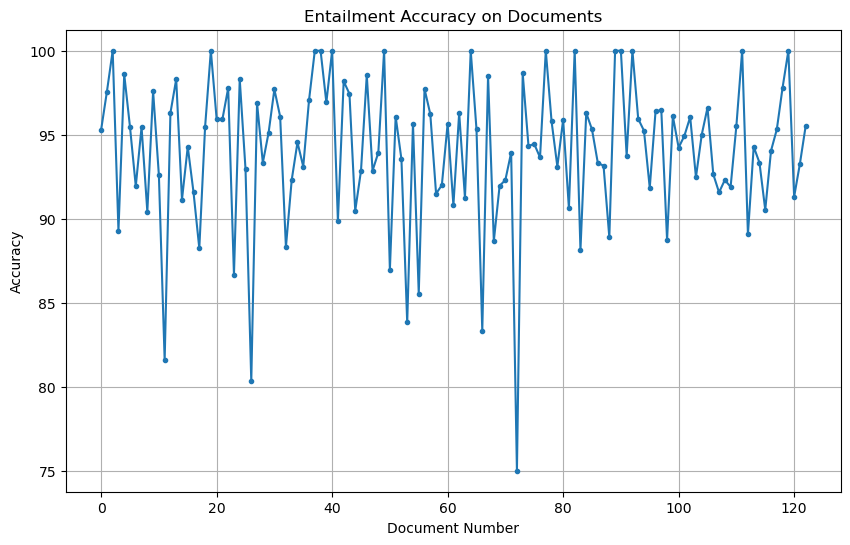

In [63]:
import re
import matplotlib.pyplot as plt

file_path = "entailment.txt"
with open(file_path, "r") as file:
    text = file.read()

accuracy_values = re.findall(r"Accuracy on Document \d+: (\d+\.\d+)", text)
accuracy_values = [float(accuracy) * 100 for accuracy in accuracy_values]

plt.figure(figsize=(10, 6))
plt.plot(accuracy_values, marker='.')
plt.title("Entailment Accuracy on Documents")
plt.xlabel("Document ID")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

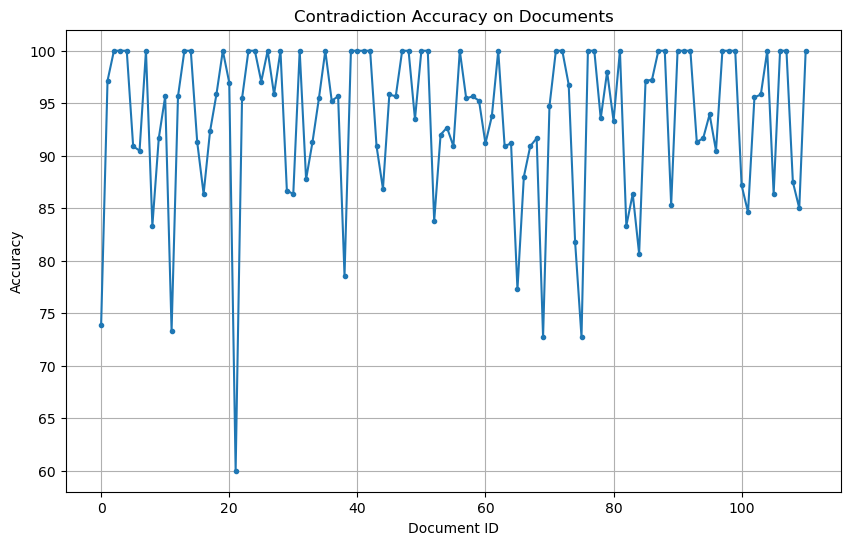

In [67]:
import re
import matplotlib.pyplot as plt

file_path = "contradiction.txt"
with open(file_path, "r") as file:
    text = file.read()

accuracy_values = re.findall(r"Accuracy on Document \d+: (\d+\.\d+)", text)
accuracy_values = [float(accuracy) * 100 for accuracy in accuracy_values]

plt.figure(figsize=(10, 6))
plt.plot(accuracy_values, marker='.')
plt.title("Contradiction Accuracy on Documents")
plt.xlabel("Document ID")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [7]:
model = BertForSequenceClassification.from_pretrained("fine-tuned-bert-entailment")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

for document in document_data["documents"]:
    for annotation_set in document["annotation_sets"]:
        annotations = annotation_set["annotations"]
        for nda, annotation in annotations.items():
            choice = annotation["choice"]
            if choice == "Entailment":
                spans_indices = annotation["spans"]
                document_spans = document["spans"]
                spans = [document_spans[i] for i in spans_indices]
                sliced_texts = [document["text"][start:end] for start, end in spans]

                random_indices = random.sample(range(len(document_spans)), min(len(document_spans) - len(spans_indices), 6))
                random_indices = [i for i in random_indices if i not in spans_indices]
                random_spans = [document_spans[i] for i in random_indices]
                random_sliced_texts = [document["text"][start:end] for start, end in random_spans]

                hypothesis = document_data["labels"][nda]["hypothesis"]
                
                for text in sliced_texts:
                    encoding = tokenizer(text, hypothesis, max_length=512, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask=True)
                    input_ids = encoding["input_ids"]
                    attention_mask = encoding["attention_mask"]

                    with torch.no_grad():
                        logits = model(input_ids, attention_mask=attention_mask)
                        probabilities = logits.logits.softmax(dim=1)

                    if probabilities[0][0] < probabilities[0][1]:
                        true_positive += 1
                    else:
                        false_negative += 1
                    
                for text in random_sliced_texts:
                    encoding = tokenizer(text, hypothesis, max_length=512, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask=True)
                    input_ids = encoding["input_ids"]
                    attention_mask = encoding["attention_mask"]

                    with torch.no_grad():
                        logits = model(input_ids, attention_mask=attention_mask)
                        probabilities = logits.logits.softmax(dim=1)

                    if probabilities[0][0] > probabilities[0][1]:
                        true_negative += 1
                    else:
                        false_positive += 1
                        
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * precision * recall / (precision + recall)
confusion_matrix = np.array([[true_positive, false_negative], [false_positive, true_negative]])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print("Confusion Matrix:")
table = PrettyTable()
table.field_names = ["", "Actual Positive", "Actual Negative"]
table.add_row(["Predicted Positive", true_positive, false_positive])
table.add_row(["Predicted Negative", false_negative, true_negative])
print(table)

Accuracy: 0.9383346425765907
Precision: 0.8748137108792846
Recall: 0.8893939393939394
F1 Score: 0.8820435762584523
Confusion Matrix:
+--------------------+-----------------+-----------------+
|                    | Actual Positive | Actual Negative |
+--------------------+-----------------+-----------------+
| Predicted Positive |       1761      |       252       |
| Predicted Negative |       219       |       5406      |
+--------------------+-----------------+-----------------+


In [8]:
model = BertForSequenceClassification.from_pretrained("fine-tuned-bert-contradiction")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

for document in document_data["documents"]:
    for annotation_set in document["annotation_sets"]:
        annotations = annotation_set["annotations"]
        for nda, annotation in annotations.items():
            choice = annotation["choice"]
            if choice == "Contradiction":
                spans_indices = annotation["spans"]
                document_spans = document["spans"]
                spans = [document_spans[i] for i in spans_indices]
                sliced_texts = [document["text"][start:end] for start, end in spans]

                random_indices = random.sample(range(len(document_spans)), min(len(document_spans) - len(spans_indices), 10))
                random_indices = [i for i in random_indices if i not in spans_indices]
                random_spans = [document_spans[i] for i in random_indices]
                random_sliced_texts = [document["text"][start:end] for start, end in random_spans]

                hypothesis = document_data["labels"][nda]["hypothesis"]
                
                for text in sliced_texts:
                    encoding = tokenizer(text, hypothesis, max_length=512, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask=True)
                    input_ids = encoding["input_ids"]
                    attention_mask = encoding["attention_mask"]

                    with torch.no_grad():
                        logits = model(input_ids, attention_mask=attention_mask)
                        probabilities = logits.logits.softmax(dim=1)

                    if probabilities[0][0] < probabilities[0][1]:
                        true_positive += 1
                    else:
                        false_negative += 1
                    
                for text in random_sliced_texts:
                    encoding = tokenizer(text, hypothesis, max_length=512, padding="max_length", truncation=True, return_tensors="pt", return_attention_mask=True)
                    input_ids = encoding["input_ids"]
                    attention_mask = encoding["attention_mask"]

                    with torch.no_grad():
                        logits = model(input_ids, attention_mask=attention_mask)
                        probabilities = logits.logits.softmax(dim=1)

                    if probabilities[0][0] > probabilities[0][1]:
                        true_negative += 1
                    else:
                        false_positive += 1
    if true_positive + true_negative + false_positive + false_negative == 0:
        continue
    
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * precision * recall / (precision + recall)
confusion_matrix = np.array([[true_positive, false_negative], [false_positive, true_negative]])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print("Confusion Matrix:")
table = PrettyTable()
table.field_names = ["", "Actual Positive", "Actual Negative"]
table.add_row(["Predicted Positive", true_positive, false_positive])
table.add_row(["Predicted Negative", false_negative, true_negative])
print(table)

Accuracy: 0.9237089201877934
Precision: 0.7285429141716567
Recall: 0.8608490566037735
F1 Score: 0.7891891891891891
Confusion Matrix:
+--------------------+-----------------+-----------------+
|                    | Actual Positive | Actual Negative |
+--------------------+-----------------+-----------------+
| Predicted Positive |       365       |       136       |
| Predicted Negative |        59       |       1996      |
+--------------------+-----------------+-----------------+


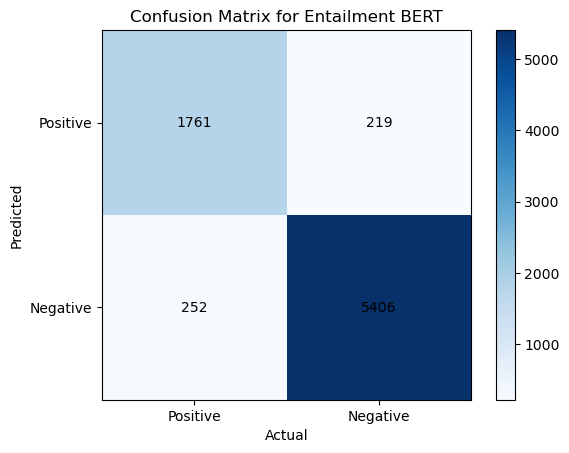

In [10]:
import matplotlib.pyplot as plt
import numpy as np

TP = 1761
TN = 5406
FP = 252
FN = 219

confusion_matrix = np.array([[TP, FN], [FP, TN]])

plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Entailment BERT')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Positive", "Negative"])
plt.yticks(tick_marks, ["Positive", "Negative"])

plt.xlabel('Actual')
plt.ylabel('Predicted')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(confusion_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='black')

plt.show()

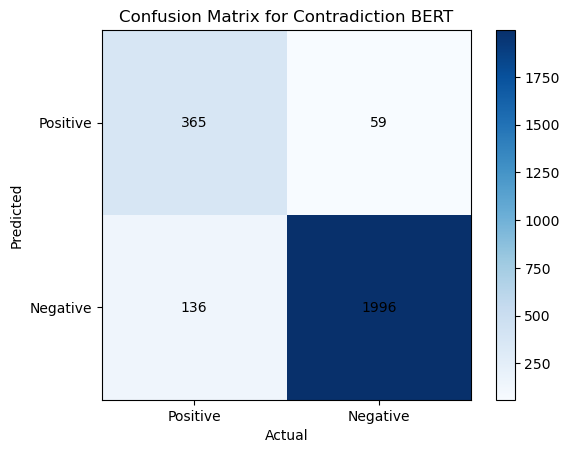

In [11]:
import matplotlib.pyplot as plt
import numpy as np

TP = 365
TN = 1996
FP = 136
FN = 59

confusion_matrix = np.array([[TP, FN], [FP, TN]])

plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Contradiction BERT')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Positive", "Negative"])
plt.yticks(tick_marks, ["Positive", "Negative"])

plt.xlabel('Actual')
plt.ylabel('Predicted')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(confusion_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='black')

plt.show()